In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

%matplotlib inline
sns.set_style('darkgrid') # use seaborn style to improve visual presentation

Using TensorFlow backend.


# 3.1 Anatomy of a Neural Network

Training a NN revolves around the following objects:
- *Layers* which are combined into a *network* (or *model*)
- The *input data* and corresponding *targets* (or *labels*)
- The *loss function*, which defines the feedback signal used for learning.
- The *optimizer*, which determines how learning proceeds

The loss function defines a function that measures how close a set of predictions are to the correct outputs.

The optimization procedure is always a form of gradient descent.  The optimization procedure use the gradients
defined by the loss function to modify the learnable parameters in the network in such a way that reduces
the loss.  The optimization procedure needs to be able to apply gradient descent back through the layers of
the network, thus a technique known as *backpropagation* is needed to take the loss from the last layer
and calculate the needed change in weights back through the network layers.

## 3.1.1 Layers: the building blocks of deep learning

A layer is a data-processing module that takes as input one (or more) tensors, and that outputs one (or more) tensors.

Some layers are stateless, but typical layers have a state: the layer's *weights* (and *biases*) which are the
learnable parameters of the model.  The collection of all of the learnable parameters of the network
contain the network's *knowledge*, e.g. they are the model that is learned that correctly transforms the
inputs to good predictions.

Different layers are appropriate for different tensor formats and different types of data.
- vectors of features: *densly connected* or *fully connected* or *dense* layer (Keras `Dense` class)
- sequence (time based) data: *recurrent layers* (Keras 'LSTM' layer)
- image data: *convolutional layers* (Keras 'Conv2D' class)

*layer compatibility* means every layer only accepts input tensors of a certain shape, and will
return tensors of a certain (usually different) shape.

In [2]:
layer = layers.Dense(32, activation='relu', input_shape=(784,))

This is the Keras way of creating a layer of fully connected (Dense) units.  There are 784 inputs (a 1D tensor of
shape (784,) ) as input to the layer, and the layer returns a 1D tensor of shape (32, ) as output.  Since the
layer is fully connected, the weight matrix of a dens layer has a (784, 32) shaped matrix of weight values (and 
will also have a (32, ) shaped vector of bias values).  As we saw in the last chapter, the forward pass of 
a dense layer performs the operations

$$
output = relu( dot(W, input) + b)
$$

So essentially for a dense layer, the forward pass is implemented in NumPy like this:

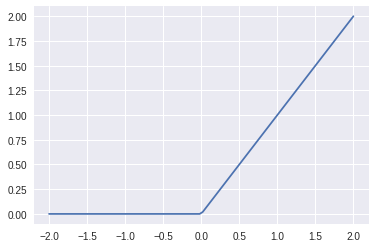

In [3]:
def relu(x):
    """REctified Linear Unit activation function
    """
    return np.maximum(x, 0)

# just a reminder, the relu activation function squashes negative output values to 0
x = np.linspace(-2.0, 2.0, 100)
plt.plot(x, relu(x))

In [4]:
input_size = 784
output_size = 32
W = np.random.normal(0.0, 0.1, (input_size, output_size)) # randomly generated 2D tensor of weights mean=0, std=0.1
b = np.random.normal(0.0, 0.1, (output_size,)) # randomly generated 2D tensor of biases values
inputs = np.random.normal(0.0, 1.0, (input_size,)) # random set of inputs

# simulate a forward pass of this layer
output = relu(np.dot(inputs, W) + b)
print(output.shape)
print(output)

(32,)
[ 4.17815101  0.          0.01035086  0.          0.          0.31934876
  0.          3.73023424  0.          0.          2.02557177  0.          0.
  0.20599072  0.          0.          0.          0.          0.
  1.09532292  0.          0.          2.78291559  1.4512884   0.07082839
  2.36160972  0.          0.          0.07841155  0.          0.
  0.80753584]


The Keras dense layer accepts only 2D tensors where the first dimension is 784 (axis 0, the batch dimension)
is unspecified.  So note, we can easily compute a batch of inputs in the previous example.  For example,
if we have a batch of 16 inputs, the previous code still works fine:

In [5]:
inputs = np.random.normal(0.0, 1.0, (16, input_size)) # input tensor of shape (16, 784), represents a batch of 16 inputs
output = relu(np.dot(inputs, W) + b)
print(output.shape)

(16, 32)


So notice that the layers like this easily handle batches of different sizes.  The number of inputs in a batch is always
dimension 0 of the input tensor, and then the output tensor from a layer like this will be (batch_size, output_size)
in shape.

For the Keras dens layer we created before, this first layer that outputs (batch_size, 32) shaped tensors can only be
connected to a downstream layer that expectes 32 dimensional vectors as input.  Keras is a high level interface
to specifying such networks, it will assume this relationship if you build networks in particular ways.  For 
instance:

In [6]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(784,)))
model.add(layers.Dense(32))

The second layer didn't receive an input shape argument, it automatically infers input from most recent layer added.
The second layer has a weight matrix of shape (32, 32).

## 3.1.2 Models: networks of layers

- A deep-learning model is a directed, acylic graph of layers.  
- Most commonly a linear stack of layers.
- But it can branch to multiple outputs
- Or have multiple branch inputs
- Or there can be some recurrent connections (Inception blocks)

The topology of a network defines a *hypothesis space*.  So what type of layers and the topology you choose will
constrain your *space of possibile tensor operations*.  e.g. different topologies imply different possible
types of tensor transformations of the inputs to outputs.  

Picking the right network architecture is still more art than science.  

# 3.1.3 Loss functions and optimizers: keys to configuring the learning process


Once you define a network architecture, you also need to choose
- *Loss function (objective function)* - The quantity that will be minimized during training.
- *Optimizer*

Choosing the right objective function for the problem is extremely important.  The objective function needs to correlate
with success for the task at hand.  For some standard types of problems, there are often well known "best" loss
functions to use:

- binary crossentropy: two-class classification
- cattegorical crossentropy: many-class classification
- mean-squared error: regression problems
- connectionist temporal classification (CTS): sequence-learning (time based) problems.


# 3.2 Introduction to Keras

Keras features: 
- CPU or GPU computation 
- high-level API, quick prototyping
- supports CNN, recurrent networks (LSTM), and any combination
- Supports arbitrary topology, multi-input or multi-output.

## 3.2.1 Keras, TensorFlow, Theano, CNTK

- Keras is a model-level library, concentrating on high-level API for defining network (model) topology
- Tensorflow, Theano, CNTK can be chosen as tensor libraries
  - These do the actual tensor level computation on GPU/CPU device
  
## 3.2.2 Developing with Keras: a quick overview

Keras workflow:

1. Define training data: input tensors and input targets
2. Define a network of layers (or *model*) that maps inputs to targets.
3. Configure learning process: loss function, optimizer and metrice to monitor
4. Iterate on training data (fit model to input training data)

There are 2 main ways to define a model in Keras: `Sequential` class (for linear stack of layers) or the
*functional API* (for directed acylic graphs of layers).

A simple example using the `Sequential` class:

In [7]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(784,)))
model.add(layers.Dense(10, activation='softmax'))

The same model defined using the Keras functional API:

In [8]:
input_tensor = layers.Input(shape=(784,))
x = layers.Dense(32, activation='relu')(input_tensor)
output_tensor = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs = input_tensor, outputs=output_tensor)

With the functional API we manipulate the data tensors that the model creates.  We need the functional
API to do more advance deep learning topologies, such as generative deep learning and reinforcement
learning combined with deep learning.  We will mostly be using the Sequential model for this class, but
will look at some of the others at the end of this class.

Once model architecture is defined (either using Sequential or functional API), th enext steps are the same.
- Compile the model, which specifies a loss function and optimizer to be used
- Then actually train (fit) the model to the data, which calculates loss from forward pass predictions, and updates
  weights based on loss using the optimization procedure.
  
Here once again is an example of compiling a model to specify the loss function

In [9]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='mse',
              metrics=['accuracy'])

This is the same as we have seen before, though here we see an example of specifying a mean squared error ('mse')
loss for the objective function, and we use a different optimization procedure than before, RMSprop
(Root Mean Square Propogation).
(see [this page](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop) for a current description
of a lot of different optimization procedures, or [the Keras optimizer documentation](https://keras.io/optimizers/)
or actually the [Wikipedia page on stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is also good).

Finally learning consists of passing Numpy arrays of input data and the corresponding target data using to a model
via the fit() method.  We haven't actually loaded any data we could use for our made up example, but fitting a 
model looks like

```python
model.fit(input_tensor, target_tensor, batch_size=128, epochs=10)
```

# 3.3 Setting up a deep-learning workstation

Recommendations: 

- Get access to a NVidia GPU
- Use a Linux distribution
- Install python scientific stack (use Anaconda), and TensorFlow and Keras

## 3.3.1 Jupyter notebooks: the preferred way to run deep-learning experiments

## 3.3.2 Getting Keras Running: two options

## 3.3.3 Running deep-learning jobs in the cloud: pros and cons

- con: expensive
- pro: can get most powerful available GPU
- pro: can be less hassel, use a preconfigure AMI with Keras and TensorFlow already installed for you

## 3.3.4 What is best GPU for deep learning?

- NVidia Titan Xp (if you can afford it) or GTX 1080 or 1060 for more modest budget.

# 3.4 Classifying movie reviews: a binary classification example

- Two-class classification: true/false, good/bad, yes/no, positive (reviews)/ negative (reviews)
- Multi-class classification is a generalization of two-class: e.g. MNIST is a 10-class classification problem

## 3.4.1 The IMDB dataset

- 50,000 highly polarized reviews
- 50/50 train/test split: 25,000 reviews for training, 25,000 reviews for test
- each set contains 50% positive reviews and 50% negative reviews.
- Task: predict if reviews are positive or negative solely from the english written words of the reviewer.

We always need to have a separate set of data we set aside for testing.  ML models can (easily) be overtrained.
They can overlearn the training data, but fail to generalize to new unseen data.  For instance, with enough
parameters a model can simply *memorize* a mapping between all training examples and the correct answer.
But a memorized mapping will usually be useless for generalizing to unseen data. What we care about is
performance on new (unseen) data.  Thus we always evaluate how well a model is doing by how well it performs
on unseen test data.

The IMDB dataset is an example prepackaged data set in Keras.  Reviews (sequence of words) have been encoded
as sequence of integers, where each word is mapped to a unique integer.  The parameter num_words=1000
in the next cell causes the data to be loaded in such a way that only the top 10,000 most frequently words in the
data are kept.  

In [10]:
# The first time you load this data may take a while, it needs to download a bunch of stuff
# from an amazon data container.  Might be wise to be on campus, or indeed run this notebook,
# and notebooks from this chapter onward, on the cheetah account
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Notice that both the train and test data are NumPy arrays with 25000
items each.  However, each training item is actually a regular python
list of words.  

These list of words are of different sizes, representing
the actual sequence of words used in different movie reviews.

Also the labels for this data are integer values, either 0 or 1,
for a negative or positive review respectively

In [11]:
# There are 25,000 data items (movie reviews) for training (and testing)
print(np.shape(train_data))
print(np.shape(train_labels))

(25000,)
(25000,)


In [12]:
# the data and labels are both stored as 1D tensor NumPy arrays.  
# However each data item is actually a regular python list of
# integer values
print(type(train_data))
print(type(train_labels))


print(type(train_data[0]))
print(type(train_labels[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.int64'>


In [13]:
# notice that each review is of a different size, because of course
# human reviewers use different numbers of words in their reviews
print(np.shape(train_data[0]))
print(np.shape(train_data[1]))

(218,)
(189,)


In [14]:
# the labels are either 0 or 1, for negative or positive reviews
print(train_labels[0])
print(train_labels[1])

1
0


In [15]:
# if we want to know what is the longest review in the training
# data set, in terms of the number of words, we can find that out
#
# looks like our largest review has 2494 words in it
max([np.shape(review)[0] for review in train_data])

2494

The words of the reviews are encoded as integers.  We only pulled
the 10000 most frequently used words for the reviews.  So the
values in the data items are encoded as values ranging from 1 to 9999.

In [16]:
min([min(sequence) for sequence in train_data])

1

In [17]:
max([max(sequence) for sequence in train_data])

9999

As described in textbook, if you want to read the actual reviews, we
need to get the index/dictionary that translates from words to the
integers used.  As mentioned in a note in text, indexes 0, 1 and 2
of the mapping are used to indicated "padding", "start of sequence"
and "unknown" tokens respectively, thus apparently you need to subtract
3 from each encoded word integer to actually decode the actual wrod
from the word index/dictionary.

In [18]:
# the maping index is another data structure that will need to be
# downloaded from an amazon data container
word_index = imdb.get_word_index()

# we reverse the mapping, so we can look up an integer code and
# decode it to a word.
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])


In [19]:
# dictionaries are common types to hold a mapping from a string key
# to some other value
print(type(word_index))

# hello is mapped to integer 4822 in the dta set
print(word_index['hello'])

# and our reverse index maps 4822 back to hello
print(reverse_word_index[4822])

# here are the code/mappings for integers 1-5
for i in range(1,6):
    print(i, reverse_word_index[i])

<class 'dict'>
4822
hello
1 the
2 and
3 a
4 of
5 to


Notice that the first 5 codings are very common words, which leads me to
believe that the mapping dictionary was probably sorted from most common
word to least common word.

Here then is the example of decoding the first review in the training
data.  The `get()` method looks up the word coding in the reverse
word dictionary.  If the code is not a valid key, '?' is returned
instead.  So all the words that were not in the top 10000 most
common words (also those speical indexes 0, 1, 2) 
will show up as '?' when you decode reviews, and the
neural network we develop next will ignore those when building
its model.

Also notice some common normalization has also been done.  All upper
case letters and punctuation have been removed (except for 's).

In [20]:
decoded_review = ' ' .join(
    [reverse_word_index.get(i - 3, '?') for i in train_data[0]])

print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

## 3.4.2 Preparing the data

The list of words are of unequal size.  We have to turn these
into tensors (regular numpy arrays), and all of the tensors
will have to be of the same size.

- Pad the lists to have same length
- One-hot encode lists

In this example the second approach is used.  All reviews get turned
into a 10,000 shaped tensor.  Note that if a word occurs multiple times,
it is simply encoded as a 1 in the tensor, so a bit of information is
lost with this type of an encoding for text processing.  Likewise,
the order of the words in the review is completely removed with a 
one-hot encoding.  But this representation is still often good enough
for categorization tasks of written text.

There are methods in scikit learn and keras to do one-hot encodings
for you.  Our textbook shows doing this by hand with a small function
for our data

In [21]:
def vectorize_sequences(sequences, dimension=10000):
    """This function expects sequences to be a sequence (array or list)
    of regular python lists, e.g. it expects our imdb train_data
    or test_data as input.  This function encodes each sequence
    into a one-hot encoding, thus the result for a set of 25,000
    sequences is a 2D tensor of shape (25000, 10000)
    
    Parameters
    ----------
    sequences - A sequence (array or list).  Each item in the sequence
       should be a regular python list of integer values, which will be
       one-hot encoded
    dimension - The number of input dimensions of the one-hot encoding,
       by default we use 10000 dimensional encoding
       
    Returns
    -------
    tensor - returns a numpy array / 2D tensor of shape (x, dimension)
       where x is the number of sequences given to encode.  Each
       column is a one-hot encoding of the corresponding integer
       sequence given as input
    """
    # create all zero tensor of shape ( len(sequences), dimension )
    # to hold the resulting one-hot encoding
    results = np.zeros((len(sequences), dimension))
    
    # we iterate through each input sequnce and encode it in the
    # results array
    for i, sequence in enumerate(sequences):
        # note the powerful fancy indexing going on here
        results[i, sequence] = 1.0
        
    return results

In [22]:
# use the function to encode as one-hot encoded vectors
x_train = vectorize_sequences(train_data)
x_test  = vectorize_sequences(test_data)

In [23]:
# The resulting 2D tensors
print(np.shape(x_train))
print(np.shape(x_test))

# and for example, the first index is used to access a particular
# review.  The 0th review has these values
print(x_train[0])

(25000, 10000)
(25000, 10000)
[ 0.  1.  1. ...,  0.  0.  0.]


And as a final step in preparing the data our textbook reformats
the training labels as floating point values.  The are currently
already numpy vectors, but they are encoded as integers.  We
need to have them encoded as floating point numbers to make sure
that the loss objective function is calculated correctly.

In [24]:
print(type(train_labels))
print(train_labels.dtype)

<class 'numpy.ndarray'>
int64


In [25]:
y_train = np.asarray(train_labels).astype('float32')
y_test  = np.asarray(test_labels).astype('float32')

## 3.4.3 Building your network

For binary (and multi-class) classification problems, where the input is a 2D tensor of shape 
(training_examples, dimensions), and the output is a one-hot encoded vector (or vector of
binary values for the binary classification case), often a simple
network of fully connected (Dense) layers can work well on the problem.  Depending on the
complexity and size of the input space, you may need more or less layers, and different
numbers of hidden units in the layers may work better or worse.

In the network used in this example, we have 2 layers of fully connected units, each with 16 hidden
units in each layer.  As we noted before, this means the first layer we add has a weight matrix of
(10000, 16) trainable parameters in it, while the second layer hass a weight matrix of (16, 16)
trainable parameters.

The final third layer we add is an output layer.  Since this is a binary classification problem,
this network has a single output, and we use a different activation function for the layer,
the sigmoid activation output.  We saw what the relu activation function looked like previously,
where it squshed all negative values to 0 and let all positive values pass through.  The sigmoid
activation function looks like this:

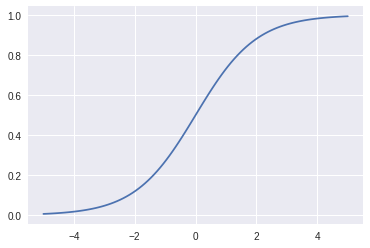

In [26]:
def sigmoid(x):
    """Implement the sigmoid activation function.  
    See [here](https://en.wikipedia.org/wiki/Sigmoid_function) for a discussion of the 
    sigmoid equation.  This function is vectorized, it expects a numpy array of values,
    and it squashes them into a value with a range from 0.0 to 1.0.  The output of
    the sigmoid activation function can be interpreted as a probability value or estimate
    ranging from 0 to 1.
    """
    return 1.0 / (1.0 + np.exp(-x))

x = np.linspace(-5.0, 5.0, 100)
plt.plot(x, sigmoid(x))

Out textbook touches briefly on the topic of what activation functions are and why they are necessary.
Activation functions produce a non-linear transformation of the input values.  This is most obvious of
the sigmoid activation function, but relu is a non-linear transformation as well.  Other commonly
used activation functions currently in deep learning are in similar families to the rectified linear
unit, like prelu and elu.

As discussed in the book, we need a non-linearity in the transformation of inputs to outputs, at least
in some of the layers of a multi-layer model.  If all tensor operations are linear operations, we can
only create models that make linear transformations of the inputs.  Things like stretching, rotating, etc.
of data are definitely non-linear, and we usually require such non-linear transformations to solve
even relatively small problems.

When creating fully connected models, there are 2 key architecture decisions to be made:

- how many layers to use
- how many hidden units to choose for each layer

Future chapters will give more information about principles to follow to make these kinds of decisions.
For this IMDB example, we use two intermediate (hidden) layers with 16 units each, and the final
output layer with a single output.

In [27]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Finally we need a [loss function](https://keras.io/losses/) and
[optimization technique](https://keras.io/optimizers/).  We choose
[binary_crossentropy](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html) to calculate
loss, as it is designed specifically for binary classification problems where the output represents the
probability of the result being a 1 or true.  

The loss function that is best will depend on the type of problem being used.  Which optimization
technique to use however is usually more independent on the type of problem.  `RMSprop` optimization
is often a good choice for optimizer no matter what type of problem you are working on.

In [28]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## 3.4.4 Validating your approach

We already have train and test data, so you may be asking why we further split out the training data
into training and validation data here.  Notice that at the end of this section, we make a final
determination that we should train the model for 4 epochs, and then test the performance on the
test data.  If you are going to be comparing several metaparameters for a model (like what number of layers
is best to use, how many hidden units, should I try a different activation function, etc.), then you
should build several such model and train them on your training data, but compare different choices
using a held back validation set.  Only after doing all such experiments to see which metaparameters
work best, should you then train a final model and check what performance it has on the completely
unseen test data set.

It is sometimes more difficult to create a validation data set.  But here we have enough data that
we can simply split our original training set into two parts, 15000 examples for training and 10000
examples we hold back to validate with.

In [29]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [30]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

Notice that we use the overall accuracy as a metric for how well the model is doing.  Keras by default returns
the value of the loss function on both the training data and on the validation data.  In addition, since we ask for
accuracy information, for each epoch we will get information about how accuracte the model is on both the
training and validation data.  Keep in mind that when batching and optimization, we are only presenting the
training data, the model is never fitted on the data in the validation set, this is only used after the end
of each epoch to measure performance on this untrained with data.

Notice that while fitting the model, the loss always decreases on the training data (as we
would expect), however the loss does not always decrease on the validation data.  Likewise
the accuracy mostly continues to increase for the training data, but it goes down a bit
as we continue to train for the validation data.
Notice also that the `fit()` function returns back a history object.  

In [31]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s - loss: 0.5161 - acc: 0.7890 - val_loss: 0.4018 - val_acc: 0.8634
Epoch 2/20
15000/15000 [==============================] - 1s - loss: 0.3147 - acc: 0.9030 - val_loss: 0.3255 - val_acc: 0.8777
Epoch 3/20
15000/15000 [==============================] - 1s - loss: 0.2322 - acc: 0.9245 - val_loss: 0.2808 - val_acc: 0.8925
Epoch 4/20
15000/15000 [==============================] - 1s - loss: 0.1819 - acc: 0.9427 - val_loss: 0.2730 - val_acc: 0.8904
Epoch 5/20
15000/15000 [==============================] - 1s - loss: 0.1504 - acc: 0.9519 - val_loss: 0.2777 - val_acc: 0.8885
Epoch 6/20
15000/15000 [==============================] - 1s - loss: 0.1220 - acc: 0.9631 - val_loss: 0.3200 - val_acc: 0.8803
Epoch 7/20
15000/15000 [==============================] - 1s - loss: 0.1044 - acc: 0.9685 - val_loss: 0.3025 - val_acc: 0.8849
Epoch 8/20
15000/15000 [==============================] - 1s 

In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

The history object that is returned contains a dictionary that has a history of everthing that happened during
training.  Since we asked for accuracy information about training, the dictionary has both loss and
accuracy measures for each epoch for both the training data and the validation data.

Lets first plot the loss for each at each epoch.  Plotting loss and accuracy at each epoch are common
visualizations to perform to analyze how the training went for a model. 

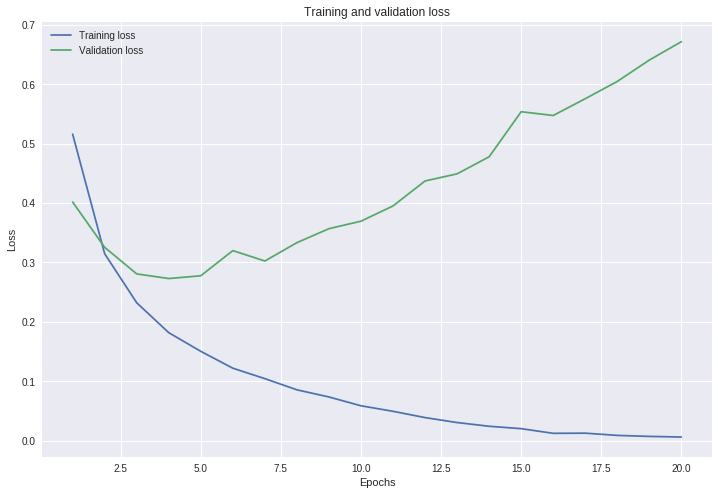

In [33]:
# visualize training and validation loss first
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Likewise we can do the same for the accuracy measure for the training and validation data as
the model trained.

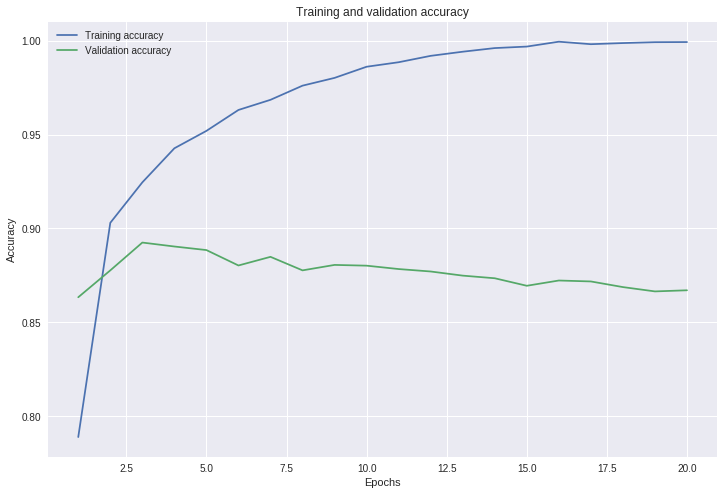

In [34]:
# visualize training and validation accuracy next
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(acc_values) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, acc_values, label='Training accuracy')
plt.plot(epochs, val_acc_values, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

As we noticed before, the training loss decreases with every epoch, and the training accuracy increases
with every epoch.  We expect this.  We are performing gradient descent optimization on losses calculated
from our training data examples, thus we are directly changing the weights to make the loss go down
for the presented training data.  And as we decrease the loss, the model is a better fit for the training
data, and thus the accuracy of the prediction on the training data increases.

However, the loss when calculated on the validation data goes down only for the first 4 epochs, and then
begins to rise again.  Likewise, accuracy plateaus when measured on the validation data at around 3 or
4 epochs at about 89% accuracy.  

This is a classic example of *overfitting* the model to the training data.  After the third or fourth
epoch the optimizer is overoptimizing on the training data. We end up overlearning representations that
are only specific to the training data, but do not generalize to data outside of the training set.
As we mentioned before, I think of overfitting as we are beginning to learn a hardcoded mapping that
maps each specific input to the correct output.  This mapping can be made to work perfectly (given
enough free parameters in the model to adjust), but it will only perform poorly, even randomly, on
data it has not learned a specific mapping for.

To prevent overfitting we could stop training after 4 epochs.  We could also explore other metaparameters, and
see if more layers or more hidden units might reduce overfitting.  If we stop there, we are essentially using
our validation data to fix that we should use a metaparameter of 4 training epochs, with the
given network architecture, in order to get the best model.  We would then do a final test to make sure
we haven't overfit the metaparameters and do get the same (best) accuracy we achieved on data we neither
used for training, or used to validate metaparameter performance.

In [35]:
# train new network for 4 epochs,
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)


Epoch 1/4
25000/25000 [==============================] - 1s - loss: 0.4719 - acc: 0.8106     
Epoch 2/4
25000/25000 [==============================] - 1s - loss: 0.2652 - acc: 0.9080     
Epoch 3/4
25000/25000 [==============================] - 1s - loss: 0.2022 - acc: 0.9277     
Epoch 4/4
24416/25000 [============================>.] - ETA: 0s

In [36]:
print(results)

[0.29119133408546449, 0.88492000000000004]


The retrained model gets about the same (almost 89% accuracy) on the completely held back training data.  

As mentioned in the textbook, a state-of-the-art approach can achive close to 95% accuracy on
this particular problem.

## 3.4.5 Using a trained network to generate predictions on new data

If we are going to use a trained model like this in a real system to, for example, categorize new reviews
from people on IMDB as being either a thumps up or a thumbs down, then we want to use the resulting trained
model to predict on new data.  The `predict()` function runs the inputs it is given through a forward pass of the
model, and retuns the final ouput layer values for each input sample.  For example:


In [37]:
model.predict(x_test)

array([[ 0.9239583 ],
       [ 0.82829618],
       [ 0.99945897],
       ..., 
       [ 0.44206911],
       [ 0.00358062],
       [ 0.81252426]], dtype=float32)

So since we used a sigmoid activation function for our final output, the value are a score between 0.0 and 1.0
for each input review we gave it.  Scores near 1 indicate the model is fairly certain this was a positive
IMDB review, and scores near 0 indicate the model is pretty certain this is a negative review.  The model can be
more uncertain, for example some values are close to 0.5

For a real production system, we would of course have to interpret this score and do something with it.  For example
we could simply use 0.5 as a threshold, and automatically mark everything below as a thumbs down, and everything
above 0.5 as a thumbs up review.  Or if we are misclassifying too many things, we could say use a threshold of 0.333
and 0.666 respectively to automatically mark positive and negative reviews, and then anything between those values
would be flagged, and we could use a different machine learning technique to try and do better, or have those items
reviewed by humans to make a final determination.

Also note that we would normally train a model separately first.  The learned parameters, once we are satisfied
we have a model that works as well as we can get it to, can simply be saved to a file.  For a deep neural
network there can be a lot of parameters.  Still it is possible to save these, then load them again to
reinstantiate a model which is ready to perform prediction on any new data that is needed.

## 3.4.6 Further experiments

State of the art performance is close to 95% accuracy on test data.  Try and experiment to improve
the model

- More or less hidden layers
- Vary the number of hiddne units
- Does a different loss function help, mse instead of binary_crossentropy
- Different activation functions like tanh

## 3.4.7 Wrapping up

- Data munging or preprocessing is often as much if not more effort and work than the actual training of a model
- Stacks of fully connected (Dense) layers with relu activaiton can solve a wide range of problems.  Classification problems where input is a vector of independent features (like words of a review) are of this type.
- In a binary classification problem (2 output classes) use a output layer with signle output using a sigmoid activation.
- And use binary_crossentropy for the loss function
- The rmsprop optimizer is generally a good enough choice
- Loss should always decrease on the training data.  If it plateaus and then starts rising again significantly on validation or test data, you are overfitting.
- Be sure to always monitor performance on data that is outside of the training set.

# 3.5 Classifying newswires: a multiclass example

We already did this, the MNIST data has 10 classes.  In previous example output class was either a 1 for positive
review, or a 0 for a negative review.  For a multiclass problem the output is a discrete set of classes.  For this
example we use the Reuters newswires data set.  In this case each article is classified into 1 of 46
mutually exclusive topics.  This is an instance of what is known as *single-label*, *multiclass classification*.

## 3.5.1 The Reuters dataset

The input is a set of articles of written english text.  So we will be encoding the input text in a similar way as
we did in previous example for the IMDB reviews.  But since this is a multiclass problem, the output will be encoded
as a (46,) one-hot encoded vector.

In [38]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [39]:
print(len(train_data))
print(len(test_data))

8982
2246


In [40]:
print(train_data.shape)
print(type(train_data))
print(type(train_data[0]))

(8982,)
<class 'numpy.ndarray'>
<class 'list'>


In [41]:
print(train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [42]:
# what is the smallest article in the training data
print( min([len(article) for article in train_data]) )

# what is the larget article in the training data
print( max([len(article) for article in train_data]) )


13
2376


There are 8982 articles in the training set, and 2246 articles in the test set.  The encoding is the same as with
the IMDB data, each word is encoded as an integer, and we can get a dictionary to map back from the integer
encodings to the words of each article.

The smallest article in the training set consists of 13 words, and the longest is 2376 words.

We can decode back articles as we did before:

In [43]:
word_index = reuters.get_word_index()

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [44]:
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


The label associated with a example is an integer betwen 0 and 45, a topic index.

In [45]:
print(train_labels[10])

# the python set data type will take a list and create a set of unique items.  We can use this to confirm
# that the labels are the set of values from 0 to 45
print(set(train_labels))

3
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45}


## 3.5.2 Preparing the data

You can vectorize the data with the exact same code as in the previous example (scroll back up to look at
the vectorize_squence function in a previous cell).  Here the result is that the train and test
data are transformed into a vector representation with 10000 dimensions, where a 1 indicates that the
corresponding word was present in the article at least 1 time, and a 0 means the word was not in the article.

In [46]:
x_train = vectorize_sequences(train_data)
x_test  = vectorize_sequences(test_data)

In [47]:
print(x_train.shape)
print(x_train[0])

(8982, 10000)
[ 0.  1.  1. ...,  0.  0.  0.]


To vectorize the labels there are two possibilities.  You could cast the label as an integer tensor, or you
can use one-hot encoding.  One-hot encoding is a widely used format for (multiclass) categorical data.
It is also called *categorical encoding* in some disciplines.  One-hot encoding consists of embedding each
label in an all-zero vector with a 1 in place of the label index.

Here we use our own function to create a one-hot encoding of the labels by hand.

In [48]:
def to_one_hot(labels, dimension=46):
    """This function takes a sequence (list or array) of multiclass label integers, and returns
    a tensor of one-hot encoded labels.  
    """
    # an initially empty 2D tensor of shape (len(labels), dimension) to hold the resulting
    # one-hot encoding.  
    results = np.zeros((len(labels), dimension))
    
    # iterate over each label and encode it as a one-hot representation
    for i, label in enumerate(labels):
        results[i, label] = 1
        
        
    return results

In [49]:
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [50]:
print(one_hot_train_labels.shape)
print(one_hot_train_labels[0])
print(train_labels[0])

(8982, 46)
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
3


Not that there is a built-in way to do this in Keras, which you've already seen in chapter 2 on the MNIST data.
There is also a similar built-in method to vectorize a sequence of data as well.

In [51]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels_keras = to_categorical(train_labels)
one_hot_test_labels_keras = to_categorical(test_labels)

In [52]:
# were the one-hot encodings identical?
np.allclose(one_hot_train_labels, one_hot_train_labels_keras)

True

## 3.5.3 Building your network

This problem is similar to previous IMDB example.  The biggest difference, because we have a multiclass output,
the number of output classes has gone from 2 to 46.

Also we used 16 units in the intermediate layers previously.  With multiple classes, the information needed
to represent all of the classes is much more complex, and 16 units may be a bottleneck in building a powerful
enough representation.  Thus we probably need to use much larger hidden layers.

In [53]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

Also note:
- Output layer is a dens layer with 46 units, so output is a 46-dimensional vector.  Each entry will encode a different
  output class.
- We use softmax activation.  You can think of this as a probability distribution over the 46 different
  output classes.  The sume of the 46 outputs will always add up to 1.
  
The best loss function to use is still crossentropy, but in this case we should be using `categorical_crossentropy`.
It measures the distance between two probability distributions, here between the probability distribution from
the softmax output layer of our network and our one-hot encoded labels

In [54]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 3.5.4 Validating your approach

We have much less data for training than before.  But as before lets validate our training by setting aside
1000 values for use as a validation set.

In [55]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Lets train the network for 20 epochs, and display the loss and accuracy curves.

In [56]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s - loss: 2.5306 - acc: 0.4962 - val_loss: 1.7180 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 0s - loss: 1.4430 - acc: 0.6878 - val_loss: 1.3435 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 0s - loss: 1.0929 - acc: 0.7661 - val_loss: 1.1704 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 0s - loss: 0.8682 - acc: 0.8166 - val_loss: 1.0788 - val_acc: 0.7600
Epoch 5/20
7982/7982 [==============================] - 0s - loss: 0.7020 - acc: 0.8483 - val_loss: 0.9844 - val_acc: 0.7830
Epoch 6/20
7982/7982 [==============================] - 0s - loss: 0.5666 - acc: 0.8796 - val_loss: 0.9401 - val_acc: 0.8030
Epoch 7/20
7982/7982 [==============================] - 0s - loss: 0.4592 - acc: 0.9039 - val_loss: 0.9090 - val_acc: 0.8010
Epoch 8/20
7982/7982 [==============================] - 0s - loss: 0.3704 - a

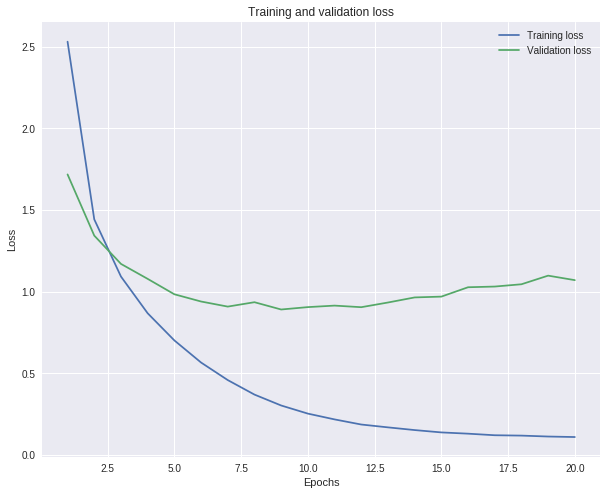

In [57]:
# plot the loss curves first
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10,8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

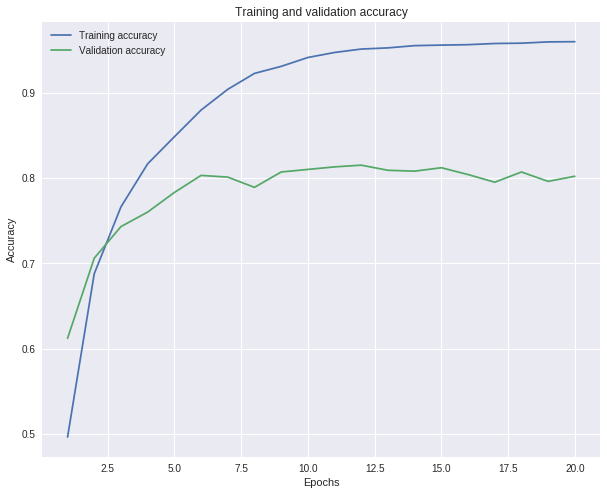

In [58]:
# plot the accuracy curves next
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,8))
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

The network begins to overfit after nine epochs.  The texbook concludes this because, when examining the
loss curves for the validation data, loss was decreasing until epoch 8 or 9, but then begins to increase again.

As before in ourtextbook example, we decide that we are done tuning, and we select 9 epochs for training, and
do a final evaluation on the test set.

In [59]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s - loss: 2.5401 - acc: 0.5226 - val_loss: 1.6792 - val_acc: 0.6540
Epoch 2/9
7982/7982 [==============================] - 0s - loss: 1.3785 - acc: 0.7096 - val_loss: 1.2825 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 0s - loss: 1.0207 - acc: 0.7781 - val_loss: 1.1321 - val_acc: 0.7550
Epoch 4/9
7982/7982 [==============================] - 0s - loss: 0.8003 - acc: 0.8256 - val_loss: 1.0531 - val_acc: 0.7560
Epoch 5/9
7982/7982 [==============================] - 0s - loss: 0.6391 - acc: 0.8628 - val_loss: 0.9743 - val_acc: 0.7950
Epoch 6/9
7982/7982 [==============================] - 0s - loss: 0.5109 - acc: 0.8933 - val_loss: 0.9090 - val_acc: 0.8120
Epoch 7/9
7982/7982 [==============================] - 0s - loss: 0.4113 - acc: 0.9144 - val_loss: 0.8919 - val_acc: 0.8230
Epoch 8/9
7982/7982 [==============================] - 0s - loss: 0.3354 - acc: 0.92

In [60]:
print(results)

[1.0235070940223212, 0.77738201251968353]


This approaches reaches about ~80% accuracy on our final test evaluation.  

With binary classification, making a random guess results in an accuracy of 50%.  With a multiclass classifier, 
a random guess would yield 1/46 = 0.02 or 2% accuracy.  However, some classes are much more likely than others.
In our data, we can get the frequency counts of the labels in our train data.  Class 3 is the most represented
in the training data, thus if we always guess class 3 we would expect about 0.35 or 35% accuracy.

In [61]:
# finds the number of articles of class 0, 1, 2 ... 45
print(np.bincount(train_labels))

# the largest class was class label 3, with 3159 articles
print(max(np.bincount(train_labels)))

# so a if we always guessed class 3, we would expect to be correct this percentage of time, assuming
# that the train data is representative of future data we might see
print(3159.0 / len(train_labels))

[  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172   26
   20  444   39   66  549  269  100   15   41   62   92   24   15   48   19
   45   39   32   11   50   10   49   19   19   24   36   30   13   21   12
   18]
3159
0.3517034068136273


The book comes up with a baseline of 19%.  In the books method, they are comparing randomly shuffling the
data around with the correct labels.  This means that random guesses are not done uniformly, but are done
with respect to the proportion of each class.  This kind of a random guessing yields about 18% to 19%
accuracy usually.

In [62]:
import copy

# test_labels_copy is a copy of the correct labels that we randomly shuffle into a new random order.
# the proportion of each class is thus the same as in the test data, but the shuffled copy represents a
# random guesser that guesses based on this ratio of the classes
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)

# vectorized operation, result is an array of booleans that is true where the guess was correct, and false 
# otherwise
hits_array = np.array(test_labels) == np.array(test_labels_copy)

# then the proportion of 'hits' or correct guesses to length is
float(np.sum(hits_array)) / len(test_labels)

0.182546749777382

## 3.5.5 Generating predictions on new data

The output from the final layer is a probability distribution because of the softmax activation function.  You can
verify this.  Let's generate topic predictions for all of the test data.

In [63]:
predictions = model.predict(x_test)

In [64]:
# each entry in predictionis is a vector of length 46
print(predictions.shape)
print(predictions[0].shape)

(2246, 46)
(46,)


The outputs for an output look like the following.  Most values are small, close to 0.  In this case, for
input 0, the topic being predicted the highest is topic 3, with a probability of 0.53, followed by topic 4, with
a predicted probability of 0.41.  Notice that the correct topic/class for input 0 is topic 3.

NOTE: The textbook trained model predicts a 4 for the test data 0.  The models will not be equivalent, they start
from different initial random weights.  In this case, the model trained for the books output was misclassifying
the test data 0.

In [65]:
# the coefficients of an output look something like this
np.set_printoptions(suppress=True)
print(predictions[0])

# The correct topic/class for this input is 3
print(test_labels[0])

# we can use argmax to find the index with the largest predicted probability.  This is useful to convert
# back from the probability distribution to the most likely class.  However, sometimes we want to give
# our second most likely guess, third most likely, etc. in which case we can use the output distribution
print(np.argmax(predictions[0]))

[ 0.0000089   0.00010717  0.00002698  0.97318041  0.01575101  0.00000013
  0.00009353  0.00003659  0.00317189  0.00000226  0.00003132  0.00135857
  0.00005724  0.00002159  0.00000485  0.00001884  0.00098275  0.00015767
  0.00026758  0.00125307  0.00078707  0.00045553  0.00000722  0.00005933
  0.00001263  0.00029455  0.00000252  0.0000249   0.00000793  0.000118
  0.0003008   0.00016602  0.00001395  0.00004198  0.0000368   0.00002069
  0.00017776  0.00005699  0.0000992   0.00027707  0.00003362  0.00042449
  0.00000159  0.00003079  0.0000069   0.00000958]
3
3


Also note that the coefficients of this (and all vectors) sum up to 1.  This is what we mean by saying that
softmax outputs a probability distribution.  The sum of all of the possible outcomes must sum up to 1.

In [66]:
print(np.sum(predictions[0]))

1.0


## 3.5.6 A different way to handle the labels and the loss

We could have used a slightly different but equivalent approach.  We could cast the labels to integer
tensors (so not one-hot encoded vectors, but just the integer class label).  If we do this we would need
to use sparse_categorical_crossentropy.  This loss function is still mathematically the same as
categorical_crossentropy.  Also we still need to use a 46 output softmax layer.

## 3.5.7 The importance of having sufficiently large intermediate layers

Small intermediate layers can be information bottlenecks.  This can be good in some situations but bad in others.
For this problem, make some hidden intermediate layers too small will probably present a bottleneck that
will reduce performance.  

For example, if one of the intermediate layers has only 4 dimensional output:

In [67]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=512,
          validation_data=(x_val, y_val))


Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s - loss: 3.2503 - acc: 0.2042 - val_loss: 2.8659 - val_acc: 0.3980
Epoch 2/20
7982/7982 [==============================] - 0s - loss: 2.6101 - acc: 0.4253 - val_loss: 2.3875 - val_acc: 0.4250
Epoch 3/20
7982/7982 [==============================] - 0s - loss: 2.1491 - acc: 0.4617 - val_loss: 2.0346 - val_acc: 0.5040
Epoch 4/20
7982/7982 [==============================] - 0s - loss: 1.8230 - acc: 0.5917 - val_loss: 1.8030 - val_acc: 0.6200
Epoch 5/20
7982/7982 [==============================] - 0s - loss: 1.5909 - acc: 0.6453 - val_loss: 1.6435 - val_acc: 0.6240
Epoch 6/20
7982/7982 [==============================] - 0s - loss: 1.4234 - acc: 0.6587 - val_loss: 1.5496 - val_acc: 0.6210
Epoch 7/20
7982/7982 [==============================] - 0s - loss: 1.3018 - acc: 0.6694 - val_loss: 1.4726 - val_acc: 0.6320
Epoch 8/20
7982/7982 [==============================] - 0s - loss: 1.2037 - a

This network will usually peak at ~70% validation accuracy, which is an 8% or 9% absolute drop (which is significant).
This drop in acdcuracy is due to trying to compress a lot of information into an intermediate space that is too
low-dimensional.  

## 3.5.8 Further experiments

- Try using larger or smaller layers: 32 units, 128 units, and so on.
- You used two hidden layers, now use a single hidden layer, or add one and try 3 hidden layers.

## 3.5.9 Wrapping up

- If doing multiclass prediction of N discrete classes, network should end with a Dense layer of size N
- In single-label multiclass classification, use softmax activation in output layer to represent an output
  probability distribution.
- Categorical crossentropy is (almost always) the loss function to use for such problems.
- We can encode lables using one-hot encoding, as we primarily did.  
  - Or we can encode labels as integers and use sparse_categorical_crossentropy loss.
  - I believe these are equivalent, they are just slightly different ways/interfaces for multiclass classification.
- Large number of output categories probably need large information spaces.  You need to avoid too small 
  intermediate layers that might create an information bottleneck.

# 3.6 Predicting house prices: a regression example

The two previous examples were classification problems.  There were 2 classes (good or bad review) or 46 classes
(46 different article categories) that we were trying to have a model learn to predict solely from an unseen
input text.  In a classification problem the labels are discrete, so the classes can be encoded as integers in such
cases.  For example, the Reuters article categories were encoded with value 0, 1, .. 45.  These encodings represents
financial articles, sports articles, and other discrete categories. 

However, another type of common prediction problem for machine learning are known as *regression* problems, which
consist of building a model to predict a continuous value.  For example, predicting tomorrows temperature given
current weather conditions.

The output value is usually a single continuous (e.g. floating point real valued number) for regression problems.
This may seem very different from trying to predict a discrete category, but once we pick an appropriate activation
function and define a suitable loss function, the optimization techniques to learn a regression are then the
same when fitting a neural network model.

## 3.6.1 The Boston housing price dataset

In this example you will try and predict the price of houses (in thousands of dollars) given a set of features, such
as the hous location, crime rate, property tax rate, size of house, etc.

This dataset is quite small compared to our previous two examples, only 506 total data points.
Also each *feature* in the input data (for example, the crime rate) has a different scale.  For instance, 
some values are porportions which range from 0 to 1, and other take values between 1 and 12, others
between 0 and 100, and so on.

Let's load and look at the data:

In [68]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [69]:
# shape of input data
print(train_data.shape)
print(test_data.shape)

# lets see what the scales of the features are for each of the 13 features in the training data are
print(np.min(train_data, axis=0))
print(np.max(train_data, axis=0))

# also lets look at the mean and standard deviation of each of the 13 features
print(np.mean(train_data, axis=0))
print(np.std(train_data, axis=0))

(404, 13)
(102, 13)
[   0.00632    0.         0.46       0.         0.385      3.561      2.9
    1.1296     1.       188.        12.6        0.32       1.73   ]
[  88.9762  100.       27.74      1.        0.871     8.725   100.
   10.7103   24.      711.       22.      396.9      37.97  ]
[   3.74511057   11.48019802   11.10443069    0.06188119    0.55735594
    6.26708168   69.01064356    3.74027079    9.44059406  405.89851485
   18.4759901   354.78316832   12.74081683]
[   9.22929073   23.73827702    6.80287253    0.24093963    0.11714785
    0.70890863   27.90606344    2.0277005     8.68758849  166.16850596
    2.19765689   93.99460145    7.24556085]


The input data consists of 13 features.  As we mentioned, the scales are quite different, as shown by finding
out the minimum and maximum value for each feature dimension for the training data above.  There are no negative
values.  There are ranges like from 0 to 100 and from 188 to 711 for example.

Also lets note that the output "targets" are encoded as floating point values.  The targets are in
thousands of dollars.  So the house prices in the test data range from a low house sales price of
\$5,600 and to a high sales price of \$50,000

In [70]:
# shape of the 'targets', e.g. the target correct output value
# each input has 1 target value, the price of the hous in thousands of dollars
print(train_targets.shape)
print(test_targets.shape)

print(test_targets)
print(np.min(test_targets))
print(np.max(test_targets))

(404,)
(102,)
[  7.2  18.8  19.   27.   22.2  24.5  31.2  22.9  20.5  23.2  18.6  14.5
  17.8  50.   20.8  24.3  24.2  19.8  19.1  22.7  12.   10.2  20.   18.5
  20.9  23.   27.5  30.1   9.5  22.   21.2  14.1  33.1  23.4  20.1   7.4
  15.4  23.8  20.1  24.5  33.   28.4  14.1  46.7  32.5  29.6  28.4  19.8
  20.2  25.   35.4  20.3   9.7  14.5  34.9  26.6   7.2  50.   32.4  21.6
  29.8  13.1  27.5  21.2  23.1  21.9  13.   23.2   8.1   5.6  21.7  29.6
  19.6   7.   26.4  18.9  20.9  28.1  35.4  10.2  24.3  43.1  17.6  15.4
  16.2  27.1  21.4  21.5  22.4  25.   16.6  18.6  22.   42.8  35.1  21.5
  36.   21.9  24.1  50.   26.7  25. ]
5.6
50.0


## 3.6.2 Preparing the data

It can be very problematic to feed data into a neural network where the input features take wildly different ranges.
The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning
more diffiecult.  

So we should first do feature-wise normalization.  For each feature, we normalize the data so it has a mean of 0 and
a standard deviation of 1. 

There are utilities in keras for doing this, or you can even define layers that
do this normalization automatically.  In all cases, what is basically happenning is that for each feature we
subtract the mean value of the feature, which shifts the means to be 0, and we divide by the standard deviation,
which will scale each feature to have a standard deviation of 1.

We can do this normalization using vectorized Numpy operations:

In [71]:
mean = train_data.mean(axis=0) # note the axis=0 parameter we used before, calculates mean for each column/feature separately
train_data -= mean # shifts each feature to have a mean of 0

std = train_data.std(axis=0)
train_data /= std # scales all features to have a unit standard deviation

# double check, now all of the features should have a mean close to 0 and a standard deviation of 1.0
print(np.mean(train_data, axis=0))
print(np.std(train_data, axis=0))

# do the same transformation of the test data
test_data -= mean
test_data /= std

[-0.  0.  0. -0. -0.  0.  0.  0.  0. -0.  0.  0.  0.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


Note that the quantities used to normalize the test data are computed using the training data means and
standard deviations.  You should never use in your workflow any quantitiy computed using the test data, even
for something as simple as data normalization.

## 3.6.3 Building your network

The training data is very small here. Paradoxically this can make it more difficult to build a good
model that generalizes well (there is not enough information in the data to build good representations).
In general, the less training data you have, the worse overfitting will be.  Using a small
network is one way to mitigate overfitting.

We are going to be introducing a technique known a cross validation next, which will require us to
build many instances of models for training.  So we will wrap the model creation in a small
function so we can reuse the code.

In [72]:
def build_model(num_features=13):
    """Build a dnn model for the Boston house prices regression problem.
    Return the model as a result of calling the function.  Each call
    to the function returns a new instance of a model for training.
    """
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(num_features,))) # don't rely on global variable inside of function as our textbook did here
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

The model has a single unit in the output layer.  Notice that we do not specify an activation
function.  With no activation function, the values are not squashed as we did before, thus the output can be a
floating point value which we can compare to the correct regression target.  So here since the
last layer is purely linear, the network is free to predict values in any range.

Also note we are using the 'mse' loss function, which stands for *mean squared error*.  This loss function is
even simplier than cross entropy, but it is suitable for regression data.  Basically the mse takes the square
of the difference between the predictions and targets as a measure of the loss function.  This is a widely used
loss function for regression problems.

You are also monitoring training using the *mean absolute error* or 'mae'.  This is simply the absolute value
of the difference between the predictions and the targets.  We need the absolute value because we want to measure
the "magnitude" of how far off our prediction was from the correct answer, no matter whether we under or over
predicted the price.  Since our prices are in thousands of dollars, a mae of 0.5 represents a prediction
being off by \$500.



## 3.6.4 Validating your approach using K-fold validation

Because the training dataset is so small this is going to cause us other problems besides being prone to overfitting.
If we split up into a single train and validation set, the validation score could vary wildly depending on which data
we end up validating with.  It doesn't really help to create multiple models but validate with the same train / validate
split.  Instead we need to create multiple models and train them, but split the date into a different
train / validation set each time.

The best practice in such situations is to use *K-fold cross validation*.  The idea is relatively simple.  Instead of
doing a single split and validation run, we do K training runs, were we split the data differently each of the K
times.  If the data is already in no particular (randomized) order, the easiest is to simply split the data into
K even pieces, then each hold back 1 of the pieces to use for validation, and training with the other K-1 pieces.

Again Keras and other machine learning frameworks have some utility functions that will do this kind of cross
validation for you.  But it is good to do it by hand a couple of times, to make sure you understand the
technique.

In [73]:
k = 4 # we will split data into 4 equal sized folds
num_val_samples = len(train_data) // k # integer division, num of values in each fold
num_epochs = 100
all_scores = []

# as a reminder, we had this number of data samples in the train data
print(len(train_data))

# so the folds are of this size
print(num_val_samples)

# if it doesn't work out exactly even for a K-fold cut thats ok, you just end up with a few extra values in 
# the last fold

404
101


To simplify a bit (in my opinion) from books presentation, lets create another helper function
that will perform a K-fold split and return the Kth fold for validation, and concatenate and return the rest of 
the folds for the train data.  Again there are utility functions in Keras and scikit-learn that will do this
for you, as long as you understand the purpose and what is happenning.

In [74]:
def kfold_validation_split_data(data, targets, fold, num_val_in_fold):
    """Split data into k folds.  Return the kth fold for validation data, and
    concatenate all other remaining folds to use for training.  The same split
    is performed on the data and the targets.
    
    Parameters
    ----------
    data - a set of training data, as a numpy array, where index 0 defines the training sample.
    targets - a set of targets for training, as a numpy array where index 0 defines the correct target
    fold - The fold number we are to pull out of data and targets to return as validation data/targets
    num_val_in_fold - the number of items in each fold
    
    Returns
    -------
    (val_data, val_targets, train_data, train_targets) - a tuple of values is returned where we
       have split the original data and targets to pull out the indicated fold for validation,
       and all other data/targets are concatenated togetheer for training
    """
    # use array slicing to pull out the indicated fold for validation
    val_data = data[fold * num_val_in_fold : (fold + 1) * num_val_in_fold]
    val_targets = targets[fold * num_val_in_fold : (fold + 1) * num_val_in_fold]
    
    # remaining data/targets are concatenated so that remaining data is used for training
    train_data = np.concatenate(
        [data[:fold * num_val_in_fold],
         data[(fold + 1) * num_val_in_fold:]],
        axis=0)
    train_targets = np.concatenate(
        [targets[:fold * num_val_in_fold],
         targets[(fold + 1) * num_val_in_fold:]],
        axis=0)
    
    # return the resulting train/validation splits
    return (val_data, val_targets, train_data, train_targets)

In [75]:
k = 4 # we will split data into 4 equal sized folds
num_val_samples = len(train_data) // k # integer division, num of values in each fold
num_epochs = 100
all_scores = []


# now perform the actual k=4 cross validations
for fold in range(k):
    print('processing fold #', fold)
    
    # split the data into validation and remaining
    (val_data, val_targets, partial_train_data, partial_train_targets) = \
        kfold_validation_split_data(train_data, train_targets, fold, num_val_samples)
        
    # create a new model to train
    model = build_model()
    
    # fit model with or validation / remaining split
    # we make verbose=0 so that we don't get training progress on standard output
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    
    # evaluate the model on the validation data for this kth fold
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [76]:
# show the results
print(all_scores)
print(np.mean(all_scores))
print(np.std(all_scores))

[2.0541220927002408, 2.2458531738507865, 2.9424394121264466, 2.3576835795204238]
2.40002456455
0.331445306056


The textbook shows validation scores from 2.6 to 3.2.  You may see quite a bit different of a range.  For example,
my first run of this had a range of the mae from 2.2 to 2.7.  But in any case, the different runs do show 
quite a bit of varriation.

In order to get a feel for if and when overtraining might be occurring, we will need to save and look
at the entire history of our evaluation metrics.  Lets rerun but save the history of the mae and loss
for each epoch so we can plot the results.

In [77]:
k = 4 # we will split data into 4 equal sized folds
num_val_samples = len(train_data) // k # integer division, num of values in each fold
num_epochs = 500
all_mae_histories = []
all_loss_histories = []

# now perform the actual k=4 cross validations
for fold in range(k):
    print('processing fold #', fold)
    
    # split the data into validation and remaining
    (val_data, val_targets, partial_train_data, partial_train_targets) = \
        kfold_validation_split_data(train_data, train_targets, fold, num_val_samples)
        
    # create a new model to train
    model = build_model()
    
    # fit model with or validation / remaining split
    # we make verbose=0 so that we don't get training progress on standard output
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    # extract history so we can plot/visualize
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    loss_history = history.history['val_loss']
    all_loss_histories.append(loss_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


You can then compute the average of the per-epoch MAE scores for all folds.  One thing to note, MAE (mean
absolute error) is the average of how far off our model was from the price.  So unlike the accuracy we used
in previous examples, a MAE of 0 is a better performance here.  The MAE is more like a loss function in that sense,
but we can directly interpret it as how much on average the predicitons of our model are from the true
values of the houses.

We first need to create an average of the MAE for each epoch, and then we can plot the evolution of the MAE
through the training epochs.

In [78]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

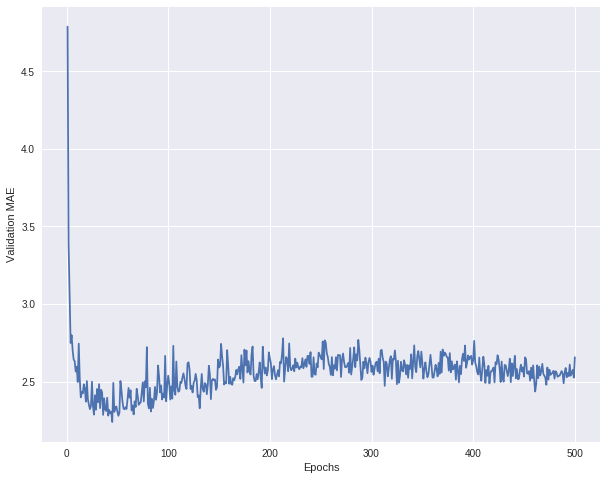

In [79]:
plt.figure(figsize=(10,8))
epochs = range(1, len(average_mae_history) + 1)
plt.plot(epochs, average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

There is still quite a bit of variation in the MAE measure, so the plot can be a bit difficult to read.  Our
textbook shows scaling the data.  Also the MAE decreases rapidly for the first couple of generations, making it
more difficult to see the change of the score.  By omitting some of these rapidly changing epochs, we can better
view the history of the mae.

Out textbook creates a small helper function to perform an exponential smoothing of the data.  Here basically
we combine 90% (the factor) of the previous point values, and add in 10% of the current score and display that.


In [80]:
def smooth_curve(points, factor=0.9):
    """Smooth the indicated points using an exponential smoothing with the indicated
    smoothing factor.
    """
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_point = previous * factor + point * (1 - factor)
            smoothed_points.append(smoothed_point)
        else:
            smoothed_points.append(point)
    return smoothed_points

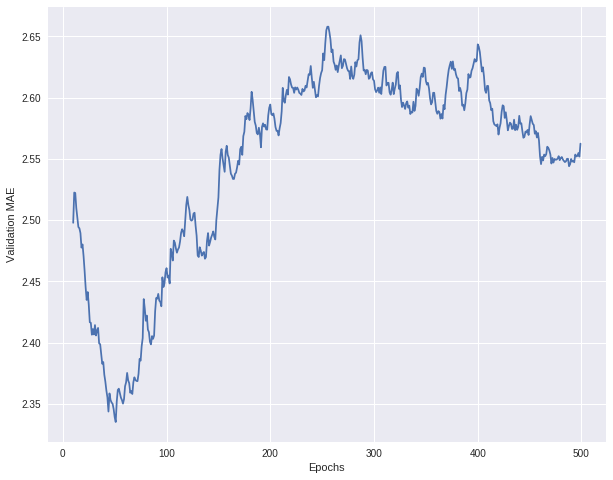

In [81]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
epochs = range(10, len(smooth_mae_history) + 10)

plt.figure(figsize=(10,8))
plt.plot(epochs, smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

Again your results may vary from our textbook when you run.  I sometimes see improvement stopping
significantly as soon as 60 epochs.  But it is clear that sometime past 60 or 80 epochs of training, the
model is being overfitted.

As a final step then, since we used the k-fold cross validation to determine the optimal number
of epochs to train with, we should do a final evaluation by training a new model from scratch and
confirming it reaches a 2.5 MAE.

In [82]:
# get a fresh model and train it
model = build_model()

# notice we train on all of the data in its entirity
model.fit(train_data, train_targets, 
          epochs=80, batch_size=16, verbose=1)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)


Epoch 1/80
404/404 [==============================] - 0s - loss: 488.9467 - mean_absolute_error: 20.2066     
Epoch 2/80
404/404 [==============================] - 0s - loss: 301.3345 - mean_absolute_error: 15.1082     
Epoch 3/80
404/404 [==============================] - 0s - loss: 133.8672 - mean_absolute_error: 9.2187     
Epoch 4/80
404/404 [==============================] - 0s - loss: 60.7275 - mean_absolute_error: 5.9211     
Epoch 5/80
404/404 [==============================] - 0s - loss: 39.1008 - mean_absolute_error: 4.6491     
Epoch 6/80
404/404 [==============================] - 0s - loss: 29.9956 - mean_absolute_error: 4.0192     
Epoch 7/80
404/404 [==============================] - 0s - loss: 25.1417 - mean_absolute_error: 3.5863     
Epoch 8/80
404/404 [==============================] - 0s - loss: 21.8854 - mean_absolute_error: 3.3615     
Epoch 9/80
404/404 [==============================] - 0s - loss: 19.8118 - mean_absolute_error: 3.1219     
Epoch 10/80
404/404 [==

404/404 [==============================] - 0s - loss: 5.9846 - mean_absolute_error: 1.7362     
Epoch 76/80
404/404 [==============================] - 0s - loss: 6.0410 - mean_absolute_error: 1.7323     
Epoch 77/80
404/404 [==============================] - 0s - loss: 6.2000 - mean_absolute_error: 1.7201      
Epoch 78/80
404/404 [==============================] - 0s - loss: 5.8906 - mean_absolute_error: 1.6906     
Epoch 79/80
404/404 [==============================] - 0s - loss: 6.0760 - mean_absolute_error: 1.7681     
Epoch 80/80
 32/102 [========>.....................] - ETA: 0s

In [83]:
print(test_mae_score)

2.69002907884


## 3.6.5 Wrapping Up

- Regression uses a different loss function than classification, typically mean squared error (MSE)
- Evaluation metrics are different.  Accuracy doesn't make sense because you can't get the target value
  exactly correct.  Mean absolute error is a common metric for regression.
- When features in input have different ranges, need to normalize the inputs and scale all the features.
- When there is little data, use K-fold validation to more reliably evaluate model.
- When little training data is available, you will need to use a small network to avoid overfitting.